Import Necessary Libraries

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

Load and Preprocess Dataset

In [12]:
# Load dataset
train = pd.read_parquet("/kaggle/input/d/shuvookd/unsw-nb15/UNSW_NB15_training-set.parquet")
test = pd.read_parquet("/kaggle/input/d/shuvookd/unsw-nb15/UNSW_NB15_testing-set.parquet")
df = pd.concat([train, test])

# Preprocessing: Drop irrelevant columns
df = df.drop(columns=['id', 'attack_cat'], errors='ignore')

# Encode categorical columns
cat_cols = ['proto', 'service', 'state']
for col in cat_cols:
    df[col] = pd.factorize(df[col])[0]

# Separate features and labels
X = df.drop('label', axis=1)
y = df['label']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.2, stratify=y, random_state=42
)

Define SimCLR Components 

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_encoder(input_dim):
    """Builds the encoder network for SimCLR."""
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='swish')(inputs)
    x = layers.Dense(128, activation='swish')(x)
    projection = layers.Dense(64)(x)  # Projection head
    return models.Model(inputs, projection)

def contrastive_loss(query, key, temperature=0.07):
    """Contrastive loss function based on SimCLR."""
    query = tf.math.l2_normalize(query, axis=1)
    key = tf.math.l2_normalize(key, axis=1)
    logits = tf.matmul(query, key, transpose_b=True) / temperature
    labels = tf.zeros(logits.shape[0], dtype=tf.int32)  # Positive pairs are the first in the logits
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, logits)
    return tf.reduce_mean(loss)

def momentum_update(student_encoder, teacher_encoder, m=0.99):
    """Momentum update for teacher encoder."""
    for student_var, teacher_var in zip(student_encoder.variables, teacher_encoder.variables):
        teacher_var.assign(m * teacher_var + (1 - m) * student_var)

def augment_batch(X):
    """Augment the batch by applying random noise."""
    mask = (np.random.rand(*X.shape) > 0.15).astype(np.float32)
    noise = np.random.normal(0, 0.05, size=X.shape).astype(np.float32)
    return X * mask + noise

Train and Evaluate for Different Train-Test Splits

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train and evaluate SimCLR with different train-test ratios
ratios = [(10,90), (20,80), (30,70), (40,60), (50,50), (60,40), (70,30), (80,20), (90,10)]
all_results = []

for train_pct, test_pct in ratios:
    print(f"\n--- Train:Test = {train_pct}:{test_pct} ---")

    # Split data according to the ratio
    X_train, X_test, y_train, y_test = train_test_split(
        X.values.astype(np.float32), y.values,
        test_size=test_pct / 100,
        stratify=y,
        random_state=42
    )

    # Initialize encoders and optimizer
    student_encoder = build_encoder(X_train.shape[1])
    teacher_encoder = build_encoder(X_train.shape[1])

    # Initialize teacher encoder weights with student encoder weights
    for s_var, t_var in zip(student_encoder.variables, teacher_encoder.variables):
        t_var.assign(s_var)

    optimizer = tf.keras.optimizers.Adam(3e-4)
    batch_size = 512
    epochs = 20
    num_samples = X_train.shape[0]

    # Train the model
    for epoch in range(epochs):
        idx = np.random.permutation(num_samples)
        X_shuffled = X_train[idx]

        for i in range(0, num_samples, batch_size):
            batch = X_shuffled[i:i + batch_size]
            if batch.shape[0] < 2:
                continue

            x_q = augment_batch(batch)
            x_k = augment_batch(batch)

            with tf.GradientTape() as tape:
                z_q = student_encoder(x_q, training=True)
                z_k = teacher_encoder(x_k, training=True)
                loss = contrastive_loss(z_q, z_k)

            grads = tape.gradient(loss, student_encoder.trainable_variables)
            optimizer.apply_gradients(zip(grads, student_encoder.trainable_variables))

            momentum_update(student_encoder, teacher_encoder)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy():.4f}")

        # Evaluate the model (Random Forest classifier on SSL embeddings)
        X_train_ssl = student_encoder.predict(X_train)
        X_test_ssl = student_encoder.predict(X_test)

        rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
        rf.fit(X_train_ssl, y_train)
        y_pred = rf.predict(X_test_ssl)
        report = classification_report(y_test, y_pred, output_dict=True)

        acc = report['accuracy']
        f1_0 = report['0']['f1-score']
        f1_1 = report['1']['f1-score']

        all_results.append({
            'train_pct': train_pct,
            'test_pct': test_pct,
            'epoch': epoch + 1,
            'loss': float(loss.numpy()),
            'accuracy': acc,
            'f1_class_0': f1_0,
            'f1_class_1': f1_1
        })

        print(f"Accuracy: {acc:.4f}, F1 Class 0: {f1_0:.4f}, F1 Class 1: {f1_1:.4f}")

# Save results to CSV file
results_df = pd.DataFrame(all_results)
results_df.to_csv('simclr_results_all_epochs.csv', index=False)
print("\nSaved results to 'simclr_results_all_epochs.csv'")


--- Train:Test = 10:90 ---
Epoch 1/20, Loss: 7.2288
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Accuracy: 0.9002, F1 Class 0: 0.8558, F1 Class 1: 0.9237
Epoch 2/20, Loss: 6.8137
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.9000, F1 Class 0: 0.8555, F1 Class 1: 0.9235
Epoch 3/20, Loss: 8.6018
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.8988, F1 Class 0: 0.8538, F1 Class 1: 0.9226
Epoch 4/20, Loss: 7.8372
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.8976, F1 Class 0: 0.8520, F1 Class 1: 0.9217
Epoch 5/20, Loss: 8.4418
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.8973, F1 Class 0: 0.8515, F1 Class 1: 0.9215
Epoch 6/20, Loss: 6.0142
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.8958, F1 Class 0: 0.8

 Visualize the Results

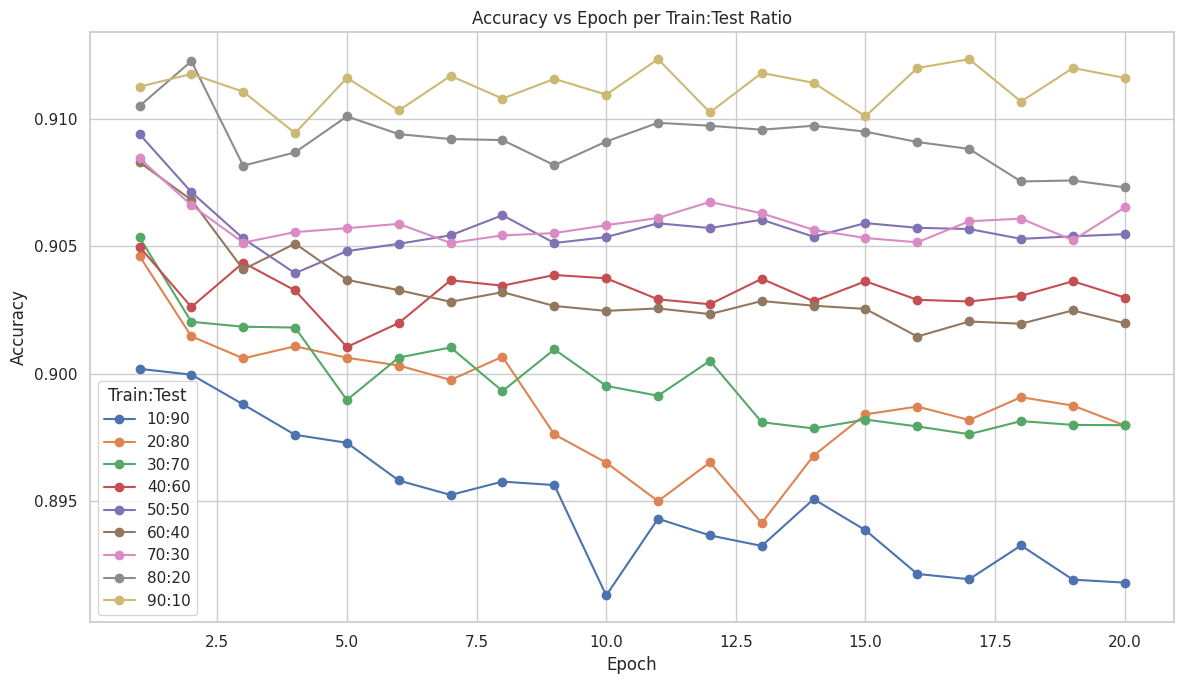

In [15]:
import seaborn as sns

sns.set(style="whitegrid")
ratios_unique = results_df[['train_pct', 'test_pct']].drop_duplicates()

# Accuracy vs Epoch
plt.figure(figsize=(12, 7))
for _, row in ratios_unique.iterrows():
    subset = results_df[
        (results_df['train_pct'] == row['train_pct']) & 
        (results_df['test_pct'] == row['test_pct'])
    ]
    label = f"{int(row['train_pct'])}:{int(row['test_pct'])}"
    plt.plot(subset['epoch'], subset['accuracy'], marker='o', label=label)
plt.title("Accuracy vs Epoch per Train:Test Ratio")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(title="Train:Test")
plt.tight_layout()
plt.show()

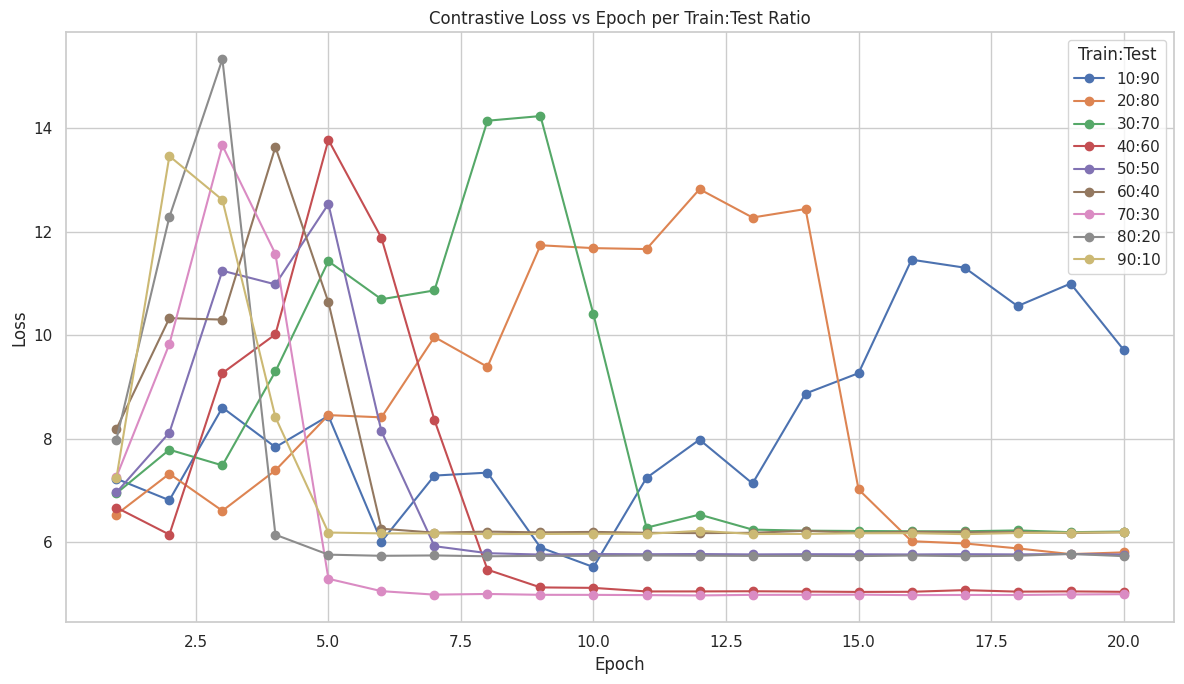

In [16]:
# Loss vs Epoch
plt.figure(figsize=(12, 7))
for _, row in ratios_unique.iterrows():
    subset = results_df[
        (results_df['train_pct'] == row['train_pct']) & 
        (results_df['test_pct'] == row['test_pct'])
    ]
    label = f"{int(row['train_pct'])}:{int(row['test_pct'])}"
    plt.plot(subset['epoch'], subset['loss'], marker='o', label=label)
plt.title("Contrastive Loss vs Epoch per Train:Test Ratio")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="Train:Test")
plt.tight_layout()
plt.show()